In [1]:
#This code computes medians of errors and uses bootstrapping to calculate errors of medians

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import bootstrap

In [6]:
errors_approximation=pd.read_csv('../data/'+ 'all_errors_' + '.csv',index_col=0)
display(errors_approximation)

columns=["sigma", "function","rmse_nn_train", "rmse_nn_test", "rmse_mdl_train", "rmse_mdl_test"]
errors_approximation=errors_approximation[columns]
display(errors_approximation)

,sigma,function,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test,n,r
0,0.0,tanh,0.038346,0.031069,0.001119,0.009678,0.048355,0.034498,0.001325,0.011692,0,0
1,0.0,tanh,0.011996,0.106369,0.002785,0.332193,0.015287,0.112211,0.003340,0.497563,1,0
2,0.0,tanh,0.045330,0.568604,0.001012,0.058189,0.119820,0.574555,0.001299,0.072254,2,0
3,0.0,tanh,0.017690,0.168191,0.000309,0.041747,0.043636,0.169878,0.000399,0.048745,3,0
4,0.0,tanh,0.015367,0.066641,0.000170,0.002949,0.019958,0.070403,0.000248,0.004091,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
655,0.2,leaky_ReLU,0.074124,0.187386,0.022778,0.125844,0.111458,0.211543,0.024829,0.152622,5,2
656,0.2,leaky_ReLU,0.117989,0.063681,0.126591,0.238867,0.142708,0.068140,0.142359,0.242984,6,2
657,0.2,leaky_ReLU,0.088039,0.255640,0.023182,0.032335,0.124684,0.268635,0.029091,0.038541,7,2
658,0.2,leaky_ReLU,0.127539,0.209643,0.098171,0.143706,0.168219,0.219296,0.114703,0.160794,8,2


,sigma,function,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test
0,0.0,tanh,0.048355,0.034498,0.001325,0.011692
1,0.0,tanh,0.015287,0.112211,0.003340,0.497563
2,0.0,tanh,0.119820,0.574555,0.001299,0.072254
3,0.0,tanh,0.043636,0.169878,0.000399,0.048745
4,0.0,tanh,0.019958,0.070403,0.000248,0.004091
...,...,...,...,...,...,...
655,0.2,leaky_ReLU,0.111458,0.211543,0.024829,0.152622
656,0.2,leaky_ReLU,0.142708,0.068140,0.142359,0.242984
657,0.2,leaky_ReLU,0.124684,0.268635,0.029091,0.038541
658,0.2,leaky_ReLU,0.168219,0.219296,0.114703,0.160794


In [7]:
#Melt dataframe to plot
errors_approximation=pd.melt(errors_approximation,id_vars=["sigma","function","rmse_nn_test","rmse_mdl_test"], var_name="error_train",value_name= "value_train")
errors_approximation=pd.melt(errors_approximation,id_vars=["sigma","function", "error_train", "value_train"], var_name="error_test", value_name= "value_test")

display(errors_approximation)

,sigma,function,error_train,value_train,error_test,value_test
0,0.0,tanh,rmse_nn_train,0.048355,rmse_nn_test,0.034498
1,0.0,tanh,rmse_nn_train,0.015287,rmse_nn_test,0.112211
2,0.0,tanh,rmse_nn_train,0.119820,rmse_nn_test,0.574555
3,0.0,tanh,rmse_nn_train,0.043636,rmse_nn_test,0.169878
4,0.0,tanh,rmse_nn_train,0.019958,rmse_nn_test,0.070403
...,...,...,...,...,...,...
2635,0.2,leaky_ReLU,rmse_mdl_train,0.024829,rmse_mdl_test,0.152622
2636,0.2,leaky_ReLU,rmse_mdl_train,0.142359,rmse_mdl_test,0.242984
2637,0.2,leaky_ReLU,rmse_mdl_train,0.029091,rmse_mdl_test,0.038541
2638,0.2,leaky_ReLU,rmse_mdl_train,0.114703,rmse_mdl_test,0.160794


In [8]:
errors_tanh=errors_approximation[errors_approximation['function']=='tanh']
errors_leaky=errors_approximation[errors_approximation['function']=='leaky_ReLU']

display(errors_tanh)
display(errors_leaky)

,sigma,function,error_train,value_train,error_test,value_test
0,0.0,tanh,rmse_nn_train,0.048355,rmse_nn_test,0.034498
1,0.0,tanh,rmse_nn_train,0.015287,rmse_nn_test,0.112211
2,0.0,tanh,rmse_nn_train,0.119820,rmse_nn_test,0.574555
3,0.0,tanh,rmse_nn_train,0.043636,rmse_nn_test,0.169878
4,0.0,tanh,rmse_nn_train,0.019958,rmse_nn_test,0.070403
...,...,...,...,...,...,...
2305,0.2,tanh,rmse_mdl_train,0.039826,rmse_mdl_test,0.118180
2306,0.2,tanh,rmse_mdl_train,0.074429,rmse_mdl_test,0.277328
2307,0.2,tanh,rmse_mdl_train,0.110881,rmse_mdl_test,0.027818
2308,0.2,tanh,rmse_mdl_train,0.076842,rmse_mdl_test,1.503048


,sigma,function,error_train,value_train,error_test,value_test
330,0.0,leaky_ReLU,rmse_nn_train,0.019052,rmse_nn_test,0.056589
331,0.0,leaky_ReLU,rmse_nn_train,0.043878,rmse_nn_test,0.270347
332,0.0,leaky_ReLU,rmse_nn_train,0.009675,rmse_nn_test,0.183943
333,0.0,leaky_ReLU,rmse_nn_train,0.047197,rmse_nn_test,0.320803
334,0.0,leaky_ReLU,rmse_nn_train,0.014963,rmse_nn_test,0.067198
...,...,...,...,...,...,...
2635,0.2,leaky_ReLU,rmse_mdl_train,0.024829,rmse_mdl_test,0.152622
2636,0.2,leaky_ReLU,rmse_mdl_train,0.142359,rmse_mdl_test,0.242984
2637,0.2,leaky_ReLU,rmse_mdl_train,0.029091,rmse_mdl_test,0.038541
2638,0.2,leaky_ReLU,rmse_mdl_train,0.114703,rmse_mdl_test,0.160794


In [9]:
#Plot results
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 8*cm; height=6*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=12;size_ticks=10;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

output_path='../results/'

resamples=100000; bs_seed=1111
ymin=2e-4;ymax=0.75

<Figure size 944.882x708.661 with 0 Axes>

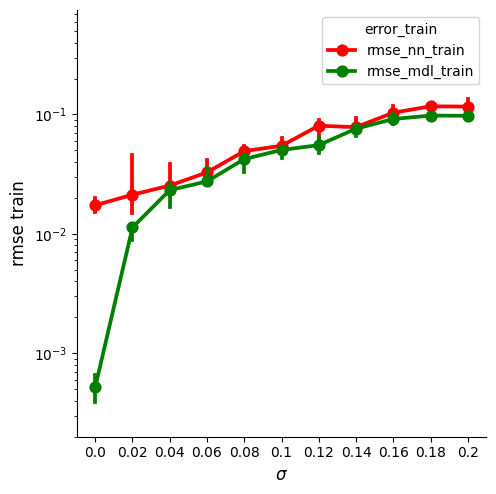

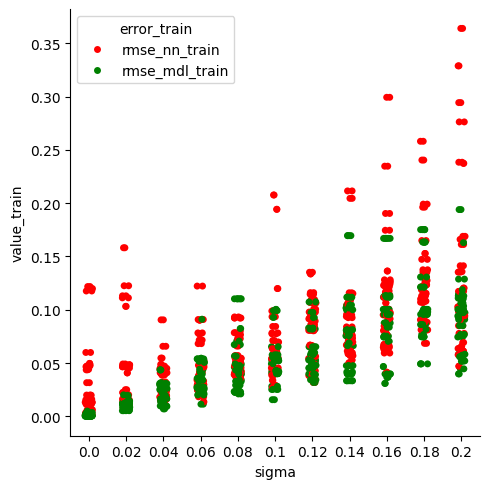

In [10]:
#tanh - rmse train
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_tanh, x='sigma', y='value_train', hue="error_train", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)


plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse train',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)


name_fig='tanh_rmse_train.svg'
plt.savefig(output_path+name_fig,dpi=300)

sns.catplot(data=errors_tanh, x='sigma', y='value_train', hue="error_train",palette=['red', 'green'],legend_out=False)
plt.show()

<Figure size 944.882x708.661 with 0 Axes>

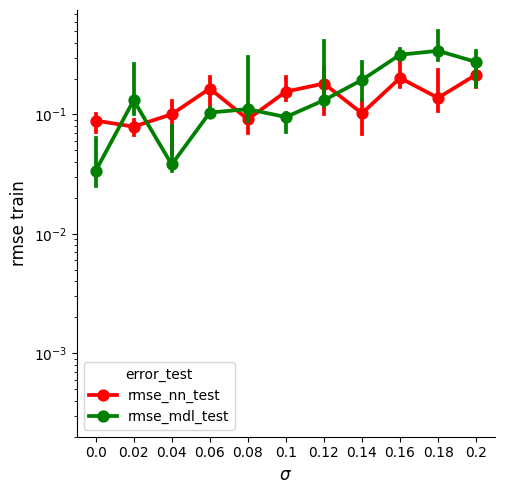

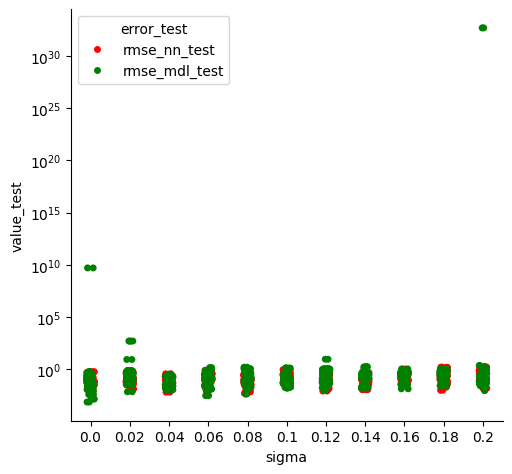

In [12]:
#tanh - rmse test
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_tanh, x='sigma', y='value_test', hue="error_test", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse train',fontsize=size_axis)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)
name_fig='tanh_rmse_test.svg'
plt.savefig(output_path+name_fig,dpi=300)

sns.catplot(data=errors_tanh, x='sigma', y='value_test', hue="error_test",palette=['red', 'green'],legend_out=False)
plt.yscale("log")
plt.show()

<Figure size 944.882x708.661 with 0 Axes>

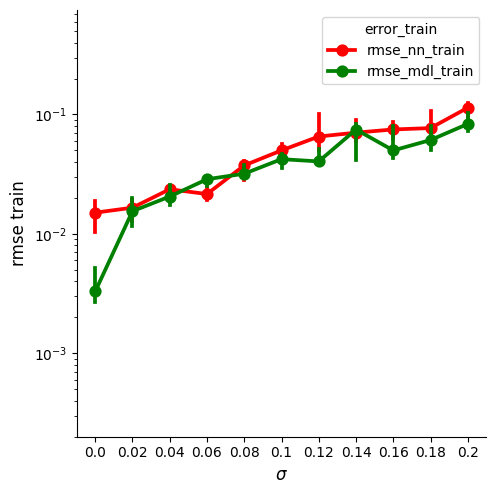

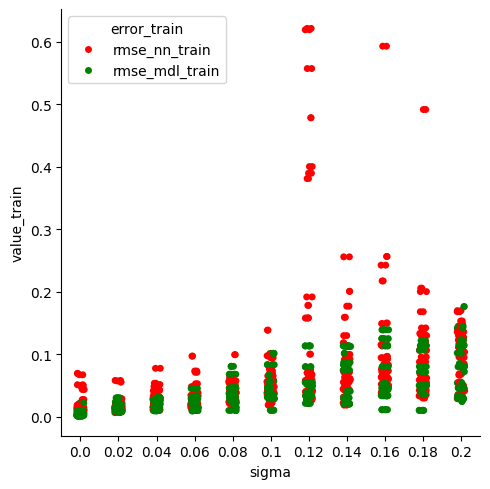

In [15]:
#leaky - rmse train
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_leaky, x='sigma', y='value_train', hue="error_train", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse train',fontsize=size_axis)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)
name_fig='leaky_rmse_train.svg'
plt.savefig(output_path+name_fig,dpi=300)

sns.catplot(data=errors_leaky, x='sigma', y='value_train', hue="error_train",palette=['red', 'green'],legend_out=False)
plt.show()

<Figure size 944.882x708.661 with 0 Axes>

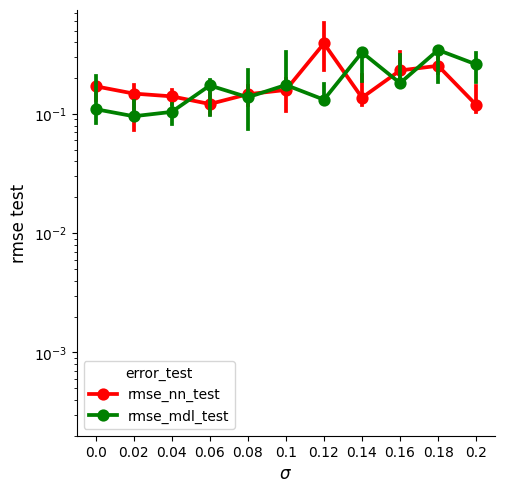

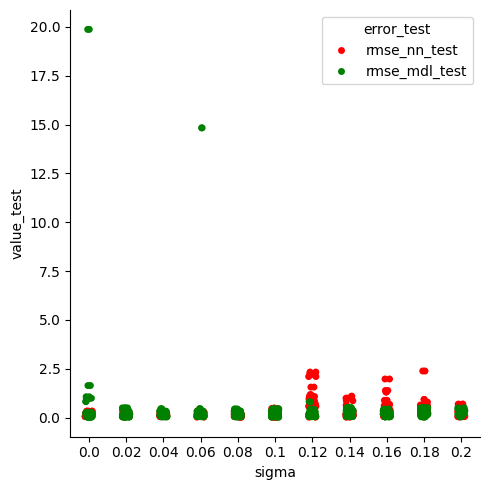

In [14]:
#leaky - rmse test
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_leaky, x='sigma', y='value_test', hue="error_test", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse test',fontsize=size_axis)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)
name_fig='leaky_rmse_test.svg'
plt.savefig(output_path+name_fig,dpi=300)

sns.catplot(data=errors_leaky, x='sigma', y='value_test', hue="error_test",palette=['red', 'green'],legend_out=False)
#plt.yscale("log")
plt.show()